## Importing libs


In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

## Loading Data

In [2]:
path = r'E:\ZiAd\Data Analysis Projects\Brazilian E-Commerce Dataset\Data'
geolocations = pd.read_csv(f'{path}/olist_geolocation_dataset.csv', encoding="utf-8")
orders = pd.read_csv(f'{path}/olist_orders_dataset.csv')
order_items = pd.read_csv(f'{path}/olist_order_items_dataset.csv')
orders_payments = pd.read_csv(f'{path}/olist_order_payments_dataset.csv')
products = pd.read_csv(f'{path}/olist_products_dataset.csv')
customers = pd.read_csv(f'{path}/olist_customers_dataset.csv')
reviews = pd.read_csv(f'{path}/olist_order_reviews_dataset.csv') 
sellers = pd.read_csv(f'{path}/olist_sellers_dataset.csv') 
product_category_name_translation = pd.read_csv(f'{path}/product_category_name_translation.csv') 

## Data Cleaning

#### Handling Missing Values & duplicates

##### geolocations

In [3]:
geolocations.isnull().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [4]:
geolocations.duplicated().sum()

np.int64(261836)

In [5]:
geolocations.drop_duplicates(inplace=True)
geolocations.duplicated().sum()

np.int64(0)

##### orders

In [6]:
columns_to_convert = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for column in columns_to_convert:
    orders[column] = pd.to_datetime(orders[column])

In [7]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [8]:
orders.loc[orders['order_delivered_customer_date'].isna(), 'order_status'].value_counts()

order_status
shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: count, dtype: int64

In [9]:
rows_to_drop = orders.loc[
    (orders['order_status'] == 'delivered') &
    (orders['order_delivered_customer_date'].isna())
].index

orders.drop(rows_to_drop, inplace=True)

In [10]:
orders.duplicated().sum()

np.int64(0)

##### order_items

In [11]:
order_items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [12]:
order_items.duplicated().sum()

np.int64(0)

##### order_payments

In [13]:
orders_payments.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [14]:
orders_payments.duplicated().sum()

np.int64(0)

##### products

In [15]:
products.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [16]:
products.duplicated().sum()

np.int64(0)

##### customers

In [17]:
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [18]:
customers.duplicated().sum()

np.int64(0)

##### reviews

In [19]:
reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [20]:
reviews.duplicated().sum()

np.int64(0)

##### sellers

In [21]:
sellers.isnull().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

In [22]:
sellers.duplicated().sum()

np.int64(0)

### Feature Engineering

In [23]:
orders['purchase_day_of_week'] = orders['order_purchase_timestamp'].dt.day_name()

orders['purchase_hour_of_day'] = orders['order_purchase_timestamp'].dt.hour

orders['seller_handling_time_days'] = (orders['order_delivered_carrier_date'] - orders['order_approved_at']).dt.days

orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

orders['shipping_time'] = (orders['order_delivered_customer_date'] - orders['order_delivered_carrier_date']).dt.days

orders['estimated_vs_actual_delivery'] = (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']).dt.days

In [24]:
order_details = order_items.groupby('order_id').agg(
    product_count=('product_id', 'nunique'),
    seller_count=('seller_id', 'nunique')
).reset_index()

orders = pd.merge(orders, order_details, on='order_id', how='left')

orders['product_count'] = orders['product_count'].fillna(0)
orders['seller_count'] = orders['seller_count'].fillna(0)

print(orders[[
    'purchase_day_of_week',
    'purchase_hour_of_day',
    'seller_handling_time_days',
    'product_count',
    'seller_count',
    'delivery_time',
    'shipping_time',
    'estimated_vs_actual_delivery'
]].head())

  purchase_day_of_week  purchase_hour_of_day  seller_handling_time_days  \
0               Monday                    10                        2.0   
1              Tuesday                    20                        0.0   
2            Wednesday                     8                        0.0   
3             Saturday                    19                        3.0   
4              Tuesday                    21                        0.0   

   product_count  seller_count  delivery_time  shipping_time  \
0            1.0           1.0            8.0            6.0   
1            1.0           1.0           13.0           12.0   
2            1.0           1.0            9.0            9.0   
3            1.0           1.0           13.0            9.0   
4            1.0           1.0            2.0            1.0   

   estimated_vs_actual_delivery  
0                          -8.0  
1                          -6.0  
2                         -18.0  
3                         -1

## Summaries & KPIs

### Sales 

##### Core Sales KPIs

In [25]:
# (Order Value) 
order_items['order_item_value'] = order_items['price'] + order_items['freight_value']

order_values = order_items.groupby('order_id')['order_item_value'].sum().reset_index()
order_values.rename(columns={'order_item_value': 'order_value'}, inplace=True)

In [26]:
# (Sales KPIs)
total_revenue = order_values['order_value'].sum()

total_orders = order_values['order_id'].nunique()

average_order_value = total_revenue / total_orders

In [27]:
print("--- Core Sales KPIs ---")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Orders: {total_orders:,}")
print(f"Average Order Value (AOV): ${average_order_value:,.2f}")

--- Core Sales KPIs ---
Total Revenue: $15,843,553.24
Total Orders: 98,666
Average Order Value (AOV): $160.58


##### Sales Trend Analysis

In [28]:
sales_trends_df = pd.merge(orders, order_values, on='order_id')
sales_trends_df.set_index('order_purchase_timestamp', inplace=True)

monthly_revenue = sales_trends_df['order_value'].resample('ME').sum()

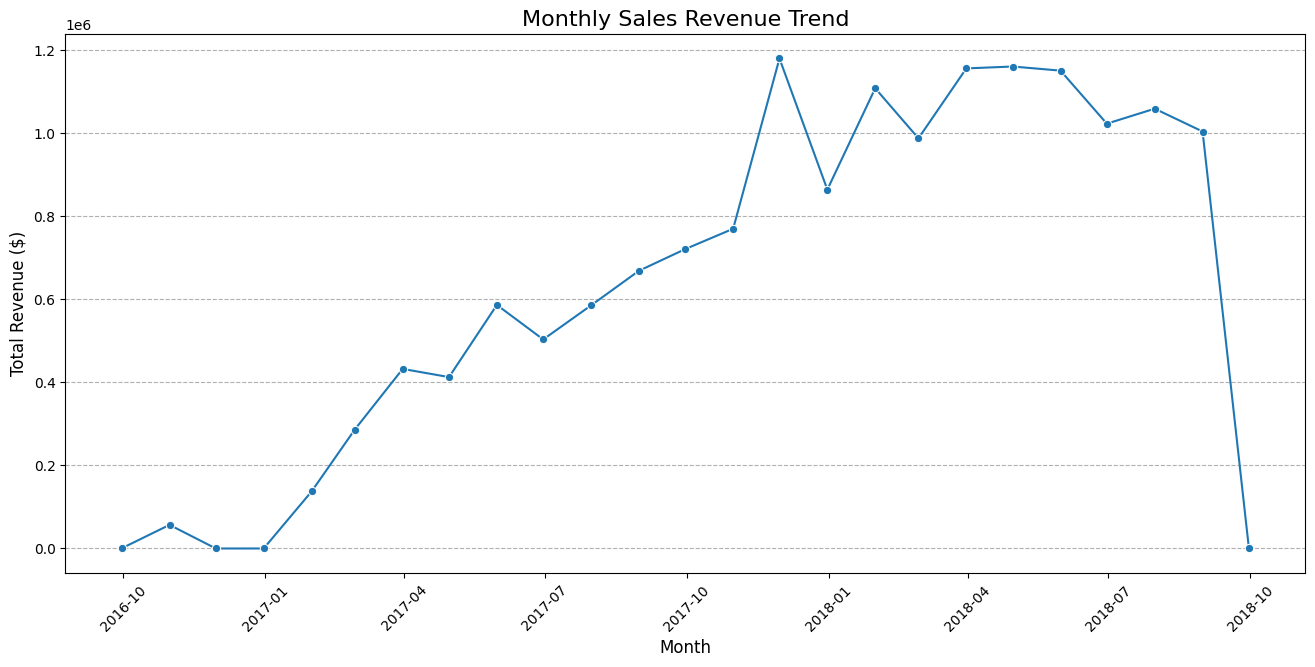

In [29]:
plt.figure(figsize=(16, 7))
sns.lineplot(x=monthly_revenue.index, y=monthly_revenue.values, marker='o')

plt.title('Monthly Sales Revenue Trend', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

In [30]:
monthly_revenue_df = monthly_revenue.to_frame(name='revenue')
monthly_revenue_df['MoM_growth'] = monthly_revenue_df['revenue'].pct_change() * 100
monthly_revenue_df.replace([np.inf, -np.inf], np.nan, inplace=True)

print("--- Monthly Revenue and MoM Growth ---")
print(monthly_revenue_df.to_string())

--- Monthly Revenue and MoM Growth ---
                             revenue     MoM_growth
order_purchase_timestamp                           
2016-09-30                    354.75            NaN
2016-10-31                  56808.84   15913.767442
2016-11-30                      0.00    -100.000000
2016-12-31                     19.62            NaN
2017-01-31                 137188.49  699127.777778
2017-02-28                 286280.62     108.676850
2017-03-31                 432048.59      50.917862
2017-04-30                 412422.24      -4.542626
2017-05-31                 585996.95      42.086651
2017-06-30                 502963.04     -14.169683
2017-07-31                 584971.62      16.305091
2017-08-31                 668204.60      14.228550
2017-09-30                 720398.91       7.811127
2017-10-31                 769312.37       6.789774
2017-11-30                1179008.94      53.254905
2017-12-31                 863547.23     -26.756516
2018-01-31               

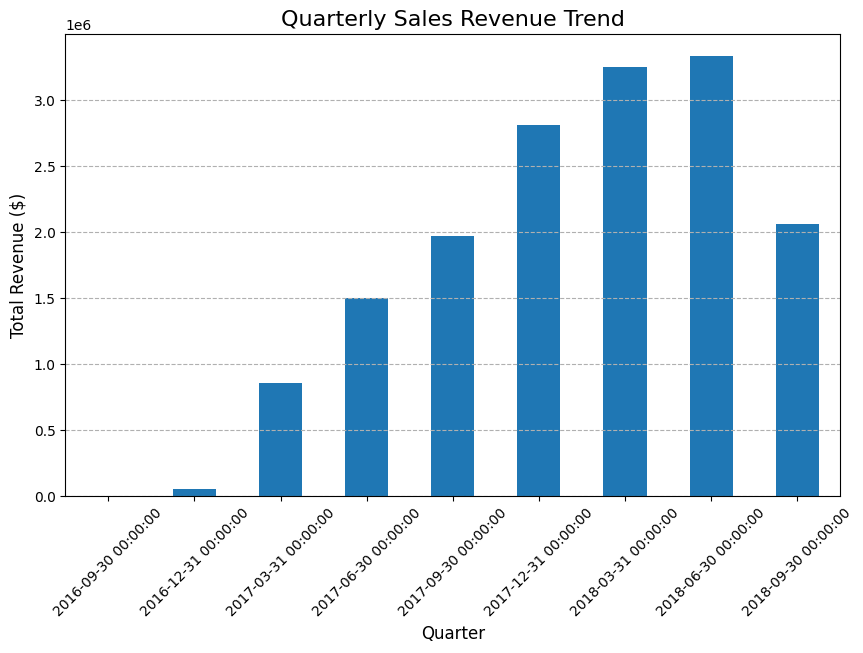

--- Quarterly Revenue Data ---
                             revenue
order_purchase_timestamp            
2016-09-30                    354.75
2016-12-31                  56828.46
2017-03-31                 855517.70
2017-06-30                1501382.23
2017-09-30                1973575.13
2017-12-31                2811868.54
2018-03-31                3249337.67
2018-06-30                3331627.64
2018-09-30                2061682.20


In [31]:
quarterly_revenue = sales_trends_df['order_value'].resample('QE').sum()

plt.figure(figsize=(10, 6))
quarterly_revenue.plot(kind='bar') 
plt.title('Quarterly Sales Revenue Trend', fontsize=16)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--')
plt.show()

print("--- Quarterly Revenue Data ---")
print(quarterly_revenue.to_frame(name='revenue').to_string())

##### Top/Bottom Categories Analysis        

In [32]:
product_details = pd.merge(order_items, products, on='product_id')
full_product_details = pd.merge(product_details, product_category_name_translation, on='product_category_name')

category_kpis = full_product_details.groupby('product_category_name_english').agg(
    total_revenue=('price', 'sum'),
    items_sold=('product_id', 'count')
).reset_index()

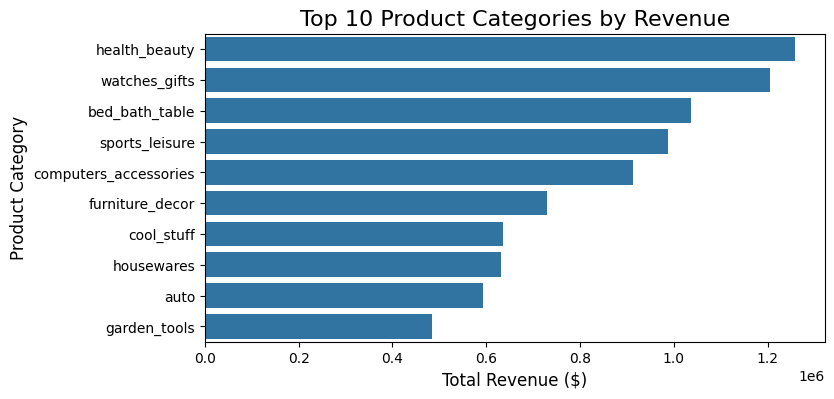

--- Top 10 Performing Categories by Revenue ---
   product_category_name_english  total_revenue  items_sold
43                 health_beauty     1258681.34        9670
70                 watches_gifts     1205005.68        5991
7                 bed_bath_table     1036988.68       11115
65                sports_leisure      988048.97        8641
15         computers_accessories      911954.32        7827
39               furniture_decor      729762.49        8334
20                    cool_stuff      635290.85        3796
49                    housewares      632248.66        6964
5                           auto      592720.11        4235
42                  garden_tools      485256.46        4347


In [33]:
top_10_categories = category_kpis.sort_values(by='total_revenue', ascending=False).head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x='total_revenue', y='product_category_name_english', data=top_10_categories)
plt.title('Top 10 Product Categories by Revenue', fontsize=16)
plt.xlabel('Total Revenue ($)', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.show()

print("--- Top 10 Performing Categories by Revenue ---")
print(top_10_categories)

In [ ]:
bottom_10_categories = category_kpis.sort_values(by='total_revenue', ascending=True).head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x='total_revenue', y='product_category_name_english', data=bottom_10_categories)
plt.title('Bottom 10 Product Categories by Revenue', fontsize=16)
plt.xlabel('Total Revenue ($)', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.show()

print("\n--- Bottom 10 Performing Categories by Revenue ---")
print(bottom_10_categories)

##### Top/Bottom Products Analysis

In [ ]:
product_kpis = full_product_details.groupby(['product_id', 'product_category_name_english']).agg(
    total_revenue=('price', 'sum'),
    items_sold=('order_id', 'count')
).reset_index()

top_10_products = product_kpis.sort_values(by='total_revenue', ascending=False).head(10)
print("\n--- Top 10 Performing Products by Revenue ---")
print(top_10_products.to_string())

In [ ]:
bottom_10_products = product_kpis.sort_values(by='total_revenue', ascending=True).head(10)
print("\n--- Bottom 10 Performing Products by Revenue ---")
print(bottom_10_products.to_string())

### Customer 

#### Unique Customers

In [ ]:
unique_customers_count = customers['customer_unique_id'].nunique()
print("--- Customer KPIs ---")
print(f"Total Unique Customers: {unique_customers_count:,}")

#### Repeat Customers

In [ ]:
customer_orders_df = pd.merge(orders, customers, on='customer_id')

order_counts_per_customer = customer_orders_df['customer_unique_id'].value_counts()

repeat_customers_count = order_counts_per_customer[order_counts_per_customer > 1].count()
repeat_customer_percentage = (repeat_customers_count / unique_customers_count) * 100

print(f"Number of Repeat Customers: {repeat_customers_count:,}")
print(f"Percentage of Repeat Customers: {repeat_customer_percentage:.2f}%")

#### Customer Lifetime Value - CLV)

In [ ]:
clv_df = pd.merge(customer_orders_df, order_values, on='order_id')

customer_lifetime_value = clv_df.groupby('customer_unique_id')['order_value'].sum().reset_index()
customer_lifetime_value.rename(columns={'order_value': 'total_spent'}, inplace=True)

top_10_customers = customer_lifetime_value.sort_values(by='total_spent', ascending=False).head(10)

print("--- Top 10 Most Valuable Customers (by Total Spending) ---")
print(top_10_customers.to_string())

#### Top States

In [ ]:
top_10_states = customers['customer_state'].value_counts().head(10)

print("--- Top 10 States by Customer Count ---")
print(top_10_states)

#### Top Cities

In [ ]:
top_10_cities = customers['customer_city'].value_counts().head(10)

print("--- Top 10 Cities by Customer Count ---")
print(top_10_cities)

#### Purchases by Day of the Week

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='purchase_day_of_week', data=orders, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Number of Orders by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.show()

#### Purchases by Hour of the Day

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='purchase_hour_of_day', data=orders)
plt.title('Number of Orders by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.show()

### Seller 

#### Total Sellers

In [ ]:
total_sellers = order_items['seller_id'].nunique()
print(f"Total Unique Sellers: {total_sellers:,}")

#### Top 10 Sellers by Total Revenue

In [ ]:
seller_revenue = order_items.groupby('seller_id')['price'].sum().reset_index()
seller_revenue.rename(columns={'price': 'total_revenue'}, inplace=True)
top_10_sellers_revenue = seller_revenue.sort_values(by='total_revenue', ascending=False).head(10)
print("--- Top 10 Sellers by Total Revenue ---")
print(top_10_sellers_revenue.to_string())

#### Top 10 Sellers by Number of Orders

In [ ]:
seller_orders = order_items.groupby('seller_id')['order_id'].nunique().reset_index()
seller_orders.rename(columns={'order_id': 'total_orders'}, inplace=True)
top_10_sellers_orders = seller_orders.sort_values(by='total_orders', ascending=False).head(10)
print("--- Top 10 Sellers by Number of Orders ---")
print(top_10_sellers_orders.to_string())

#### Seller Handling Time

In [ ]:
seller_handling_df = pd.merge(orders, order_items, on='order_id')
avg_handling_time = seller_handling_df.groupby('seller_id')['seller_handling_time_days'].mean().reset_index()
avg_handling_time.rename(columns={'seller_handling_time_days': 'avg_handling_days'}, inplace=True)
fastest_sellers = avg_handling_time.sort_values(by='avg_handling_days', ascending=True).head(10)

print("--- Top 10 Fastest Sellers (by Average Handling Time in Days) ---")
print(fastest_sellers.to_string())

#### Overall Top 10 Sellers

In [ ]:
seller_summary = pd.merge(seller_revenue, seller_orders, on='seller_id')
seller_summary = pd.merge(seller_summary, avg_handling_time, on='seller_id')
top_10_sellers_summary = seller_summary.sort_values(by='total_revenue', ascending=False).head(10)

print("--- Overall Top 10 Sellers ---")
print(top_10_sellers_summary.to_string())

### Logistics 

#### Core Logistics KPIs

In [ ]:
avg_delivery_time = orders['delivery_time'].mean()
avg_shipping_time = orders['shipping_time'].mean()
avg_estimated_vs_actual = orders['estimated_vs_actual_delivery'].mean()

print("--- Core Logistics KPIs ---")
print(f"Average Total Delivery Time: {avg_delivery_time:.2f} days")
print(f"Average Shipping Time (Carrier): {avg_shipping_time:.2f} days")
print(f"Average Estimated vs. Actual Delivery: {avg_estimated_vs_actual:.2f} days")

#### Late Orders %

In [ ]:
orders['is_late'] = orders['estimated_vs_actual_delivery'] > 0

late_orders_count = orders['is_late'].sum()
total_delivered_orders = orders['order_delivered_customer_date'].notna().sum()
late_orders_percentage = (late_orders_count / total_delivered_orders) * 100
print(f"Percentage of Late Orders: {late_orders_percentage:.2f}%")

#### Delivery Time Distribution

In [ ]:
plt.figure(figsize=(12, 7))
sns.histplot(data=orders, x='delivery_time', bins=50, kde=True) 
plt.title('Distribution of Total Delivery Time', fontsize=16)
plt.xlabel('Total Delivery Time (Days)', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.show()

#### Top 10 States by Delayed Order Count

In [ ]:
late_orders = orders[orders['is_late'] == True]
late_orders_geo = pd.merge(late_orders, customers, on='customer_id')

top_10_late_states = late_orders_geo['customer_state'].value_counts().head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_10_late_states.index, y=top_10_late_states.values)
plt.title('Top 10 States with the Most Delayed Orders', fontsize=16)
plt.xlabel('State Code', fontsize=12)
plt.ylabel('Number of Delayed Orders', fontsize=12)
plt.show()

print("--- Top 10 States by Delayed Order Count ---")
print(top_10_late_states)

#### Top 10 States by Late Order Rate

In [ ]:
orders_with_geo = pd.merge(orders, customers, on='customer_id')
state_performance = orders_with_geo.groupby('customer_state').agg(
    total_orders=('order_id', 'count'),
    late_orders=('is_late', 'sum') # 'is_late' is boolean (True=1, False=0), so sum() counts the late ones
).reset_index()

state_performance['late_order_rate'] = (state_performance['late_orders'] / state_performance['total_orders']) * 100
top_10_late_rate_states = state_performance.sort_values(by='late_order_rate', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='late_order_rate', y='customer_state', data=top_10_late_rate_states)
plt.title('Top 10 States by Percentage of Delayed Orders', fontsize=16)
plt.xlabel('Late Order Rate (%)', fontsize=12)
plt.ylabel('State Code', fontsize=12)
plt.show()

print("--- Top 10 States by Late Order Rate ---")
print(top_10_late_rate_states)

### Payment 

#### Payment Methods Distribution

In [ ]:
payment_distribution = orders_payments['payment_type'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(x=payment_distribution.index, y=payment_distribution.values)
plt.title('Distribution of Payment Methods', fontsize=16)
plt.xlabel('Payment Type', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=45)
plt.show()

print("--- Payment Methods Distribution ---")
print(payment_distribution)

#### Total Payment Value by Payment Type

In [ ]:
value_per_payment_type = orders_payments.groupby('payment_type')['payment_value'].sum().sort_values(ascending=False)
print("--- Total Payment Value by Payment Type ---")
print(value_per_payment_type)

#### Distribution of Installments

In [ ]:
credit_card_payments = orders_payments[orders_payments['payment_type'] == 'credit_card']
avg_installments = credit_card_payments['payment_installments'].mean()

print("--- Installment KPIs (for Credit Card payments) ---")
print(f"Average number of installments: {avg_installments:.2f}")

In [ ]:
installments_distribution = credit_card_payments['payment_installments'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=installments_distribution.index, y=installments_distribution.values)
plt.title('Distribution of Payment Installments (Credit Card)', fontsize=16)
plt.xlabel('Number of Installments', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.show()

print("\n--- Distribution of Installments ---")
print(installments_distribution)

#### Electronic vs. Cash/Voucher Payment Ratio

In [ ]:
def classify_payment(payment_type):
    if payment_type in ['credit_card', 'debit_card']:
        return 'Electronic'
    else: 
        return 'Cash / Voucher'

orders_payments['payment_category'] = orders_payments['payment_type'].apply(classify_payment)
payment_category_dist = orders_payments['payment_category'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(payment_category_dist, labels=payment_category_dist.index, autopct='%1.1f%%', startangle=140)
plt.title('Electronic vs. Cash/Voucher Payment Ratio', fontsize=16)
plt.ylabel('') # Hide the y-label as it's not needed for a pie chart
plt.show()

print("--- Payment Category Distribution ---")
print(payment_category_dist)

### Review 

#### Review Score

In [ ]:
score_distribution = reviews['review_score'].value_counts().sort_index()

plt.figure(figsize=(8, 2))
sns.barplot(x=score_distribution.index, y=score_distribution.values)
plt.title('Distribution of Review Scores', fontsize=16)
plt.xlabel('Review Score (Stars)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

print("--- Review Score Distribution ---")
print(score_distribution)

In [ ]:
average_score = reviews['review_score'].mean()

print("--- Average Review Score ---")
print(f"The overall average review score is: {average_score:.2f} out of 5")

#### Average Delivery Time per Review Score

In [ ]:
reviews_with_delivery = pd.merge(reviews, orders, on='order_id')
avg_delivery_per_score = reviews_with_delivery.groupby('review_score')['delivery_time'].mean().reset_index()

plt.figure(figsize=(10, 4))
sns.barplot(x='review_score', y='delivery_time', data=avg_delivery_per_score)
plt.title('Average Delivery Time per Review Score', fontsize=16)
plt.xlabel('Review Score (Stars)', fontsize=10)
plt.ylabel('Average Delivery Time (Days)', fontsize=10)
plt.show()

print("--- Average Delivery Time per Review Score ---")
print(avg_delivery_per_score)

#### Top Positive vs Negative Categories

In [ ]:
reviews_items = pd.merge(reviews, order_items, on='order_id')
reviews_products = pd.merge(reviews_items, products, on='product_id')
full_review_details = pd.merge(reviews_products, product_category_name_translation, on='product_category_name')

avg_score_per_category = full_review_details.groupby('product_category_name_english')['review_score'].mean().reset_index()

top_rated_categories = avg_score_per_category.sort_values(by='review_score', ascending=False).head(10)
print("--- Top 10 Best Rated Product Categories ---")
print(top_rated_categories.to_string())

bottom_rated_categories = avg_score_per_category.sort_values(by='review_score', ascending=True).head(10)
print("\n--- Bottom 10 Worst Rated Product Categories ---")
print(bottom_rated_categories.to_string())

### Customer Segmentation using RFM

In [ ]:
rfm_base_df = pd.merge(customers, orders, on='customer_id')
rfm_base_df = pd.merge(rfm_base_df, order_values, on='order_id')

snapshot_date = rfm_base_df['order_purchase_timestamp'].max() + dt.timedelta(days=1)
recency_df = rfm_base_df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
recency_df['recency'] = (snapshot_date - recency_df['order_purchase_timestamp']).dt.days

frequency_df = rfm_base_df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
frequency_df.rename(columns={'order_id': 'frequency'}, inplace=True)

monetary_df = rfm_base_df.groupby('customer_unique_id')['order_value'].sum().reset_index()
monetary_df.rename(columns={'order_value': 'monetary'}, inplace=True)

rfm_df = pd.merge(recency_df[['customer_unique_id', 'recency']], frequency_df, on='customer_unique_id')
rfm_df = pd.merge(rfm_df, monetary_df, on='customer_unique_id')

In [ ]:
rfm_df['R_Score'] = pd.qcut(rfm_df['recency'], q=4, labels=[4, 3, 2, 1]).astype(int)
rfm_df['F_Score'] = pd.qcut(rfm_df['frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4]).astype(int)
rfm_df['M_Score'] = pd.qcut(rfm_df['monetary'], q=4, labels=[1, 2, 3, 4]).astype(int)

rfm_df['RFM_Score'] = rfm_df['R_Score'] + rfm_df['F_Score'] + rfm_df['M_Score']

print("---  RFM Scores Calculated ---")
print(rfm_df[['customer_unique_id', 'recency', 'frequency', 'monetary', 'RFM_Score']].head())

In [ ]:
def assign_segment_name(score):
    if score >= 10:
        return 'Best Customers' 
    elif score >= 7:
        return 'Potential Loyalists'
    elif score >= 5:
        return 'At Risk Customers'
    else:
        return 'Lost Customers'


rfm_df['RFM_Segment_Name'] = rfm_df['RFM_Score'].apply(assign_segment_name)

segment_analysis = rfm_df.groupby('RFM_Segment_Name').agg(
    customer_count=('customer_unique_id', 'count'),
    avg_recency=('recency', 'mean'),
    avg_frequency=('frequency', 'mean'),
    avg_monetary=('monetary', 'mean'),
    avg_RFM_Score=('RFM_Score', 'mean')
).sort_values(by='avg_RFM_Score', ascending=False)

plt.figure(figsize=(10, 4))
sns.countplot(y='RFM_Segment_Name', data=rfm_df, order=segment_analysis.index)
plt.title('Customer Segmentation based on RFM Score', fontsize=16)
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Segment', fontsize=12)
plt.show()

print("--- Analysis of Customer Segments ---")
print(segment_analysis)